In [1]:
## Imports and adapted functions
from CNN2D                import CNN2D, train_model, test_model, analyse_train_test
from gniadecka_functions  import first_derivative_bl_removal
from subimages            import subimages, reconstruct_img
from fake_data            import make_peak, add_noise, add_baseline, make_map, my_pca
from accuracy             import evaluate_performance
import numpy as np
import matplotlib.pyplot as plt

In [23]:
LEARNING_RATE  = 0.01
EPOCHS        = 5000
DROPOUT_RATE  = 0.1
TRAIN_CUTOFF  = 1200
SUBIMG_SPACING= 5
IMG_WIDTH     = 10
PCA_COMPONENTS= 50
N_BCC_LIM     = 20
BL_AMPLITUDE  = 50
PEAK_HEIGHTS  = [30,60]
PEAK_WIDTHS   = [20,10]
NOISE_STD     = 5

In [12]:
parameters = {
    'LEARNING_RATE' : 0.01,
    'EPOCHS'        : 5000,
    'DROPOUT_RATE'  : 0.1,
    'TRAIN_CUTOFF'  : 1200,
    'SUBIMG_SPACING': 5,
    'IMG_WIDTH'     : 10,
    'PCA_COMPONENTS': 20,
    'N_BCC_LIM'     : 20,
    'BL_AMPLITUDE'  : 50,
    'PEAK_HEIGHTS'  : [30,60],
    'PEAK_WIDTHS'   : [20,10],
    'NOISE_STD'     : 3
}

In [4]:
bcc_map = make_map()

healthy = np.zeros((1024))
bcc     = np.zeros((1024))

for i in range(5): # 5 big peaks
    healthy = make_peak(healthy, PEAK_HEIGHTS[0], PEAK_HEIGHTS[1], PEAK_WIDTHS[0])
    bcc     = make_peak(bcc    , PEAK_HEIGHTS[0], PEAK_HEIGHTS[1], PEAK_WIDTHS[0])
for i in range(10): # 10 small peaks
    healthy = make_peak(healthy, 1, PEAK_HEIGHTS[0], PEAK_WIDTHS[1])
    bcc     = make_peak(bcc    , 1, PEAK_HEIGHTS[0], PEAK_WIDTHS[1])

# Remove negative elements (make_peak can return negative values)
healthy = [0 if i < 0 else i for i in healthy]
bcc     = [0 if i < 0 else i for i in bcc]

###############################################
## 2. Add 0-mean Gaussian noise
mean = 0
img_spectra = add_noise(bcc_map, healthy,bcc,mean,NOISE_STD)

###############################################
## 3. Add and remove baseline
for i in range(200):
    for j in range(200):
        img_spectra[i,j]     = add_baseline(img_spectra[i,j],BL_AMPLITUDE)
        x = np.linspace(0,1023,1024)
        [img_spectra[i,j],_] = first_derivative_bl_removal(x,img_spectra[i,j])


In [24]:
###############################################
## 4. Perform PCA
pca_reduced = my_pca(bcc_map,img_spectra,PCA_COMPONENTS)

In [25]:
###############################################
## 5. Get sub-images
t_map = pca_reduced.reshape(40000,PCA_COMPONENTS)
t_target = bcc_map
width = 200

sub_images = []
target = []
for i in range(0,200-IMG_WIDTH+1,SUBIMG_SPACING): 
    for j in range(0,200-IMG_WIDTH+1,SUBIMG_SPACING):  
        spectra = np.zeros((IMG_WIDTH,IMG_WIDTH,PCA_COMPONENTS))
        
        for line in range(IMG_WIDTH):
            index = (i+line)*width + j
            spectra[:,line,:] = t_map[index:index+IMG_WIDTH,:]
        
        final_spectra = []
        # Change data structure from (40*40,PCA_COMPONENTS) to (PCA_COMPONENTS,40,40)
        for k in range(PCA_COMPONENTS):
            final_spectra.append(np.transpose(spectra[:,:,k]))
        
        sub_images.append(final_spectra)


        bcc = t_target[i:i+IMG_WIDTH,j:j+IMG_WIDTH]
        #target.append(bcc)
        if np.count_nonzero(bcc) > N_BCC_LIM:
            target.append(1)
        else:
            target.append(0)

In [26]:
## 6. CNN
model = CNN2D(IMG_WIDTH,PCA_COMPONENTS,DROPOUT_RATE)
train_model(model, sub_images[:TRAIN_CUTOFF], target[:TRAIN_CUTOFF], LEARNING_RATE, EPOCHS, IMG_WIDTH, PCA_COMPONENTS)

approximation_train = test_model(model, sub_images[:TRAIN_CUTOFF], IMG_WIDTH, PCA_COMPONENTS)
approximation_test  = test_model(model, sub_images[TRAIN_CUTOFF:], IMG_WIDTH, PCA_COMPONENTS)

100%|██████████| 5000/5000 [02:16<00:00, 36.51it/s]


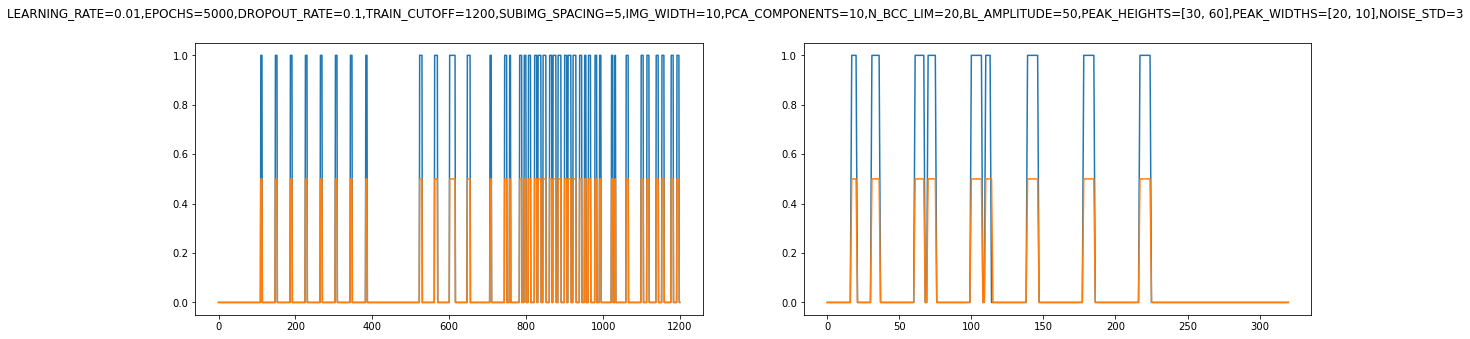

In [7]:
train_res, test_res, _ = analyse_train_test(approximation_train, approximation_test, target, TRAIN_CUTOFF, parameters, plot=1, text=1)
total_res = train_res
for i in test_res:
    total_res.append(i)
    
reconstructed = reconstruct_img(total_res, [200,200], IMG_WIDTH, SUBIMG_SPACING)

In [8]:
sensitivity, specificity, precision, accuracy, confusion_matrix = evaluate_performance(total_res,target)

In [9]:
print(sensitivity)
print(specificity)
print(precision)
print(accuracy)

1.0
0.9991783073130649
0.9967213114754099
0.9993425378040762


# Test run-time with and without PCA

In [10]:
###############################################
## 5. Get sub-images
t_map = img_spectra.reshape(40000,1024)
t_target = bcc_map
width = 200

sub_images = []
target = []
for i in range(0,200-IMG_WIDTH+1,SUBIMG_SPACING): 
    for j in range(0,200-IMG_WIDTH+1,SUBIMG_SPACING):  
        spectra = np.zeros((IMG_WIDTH,IMG_WIDTH,1024))
        
        for line in range(IMG_WIDTH):
            index = (i+line)*width + j
            spectra[:,line,:] = t_map[index:index+IMG_WIDTH,:]
        
        final_spectra = []
        # Change data structure from (40*40,PCA_COMPONENTS) to (PCA_COMPONENTS,40,40)
        for k in range(1024):
            final_spectra.append(np.transpose(spectra[:,:,k]))
        
        sub_images.append(final_spectra)

        bcc = t_target[i:i+IMG_WIDTH,j:j+IMG_WIDTH]
        #target.append(bcc)
        if np.count_nonzero(bcc) > N_BCC_LIM:
            target.append(1)
        else:
            target.append(0)

In [11]:
## 6. CNN
model = CNN2D(IMG_WIDTH,1024,DROPOUT_RATE)
train_model(model, sub_images[:TRAIN_CUTOFF], target[:TRAIN_CUTOFF], LEARNING_RATE, EPOCHS, IMG_WIDTH, 1024)

100%|██████████| 5000/5000 [26:43<00:00,  3.12it/s]


CNN2D(
  (conv1): Conv2d(1024, 10, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=250, out_features=100, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

# Info in each IDX layer

In [4]:
import scipy.io as scio
import matplotlib.pyplot as plt
data = scio.loadmat('../Data/tissue3_1.mat')
idx = data['IDX']

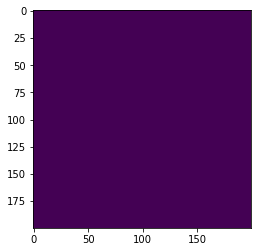

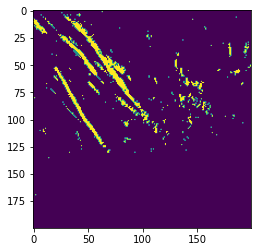

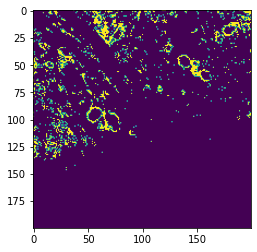

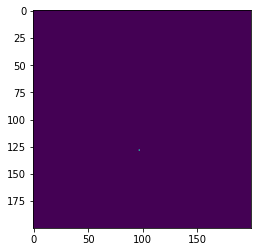

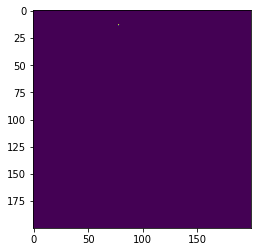

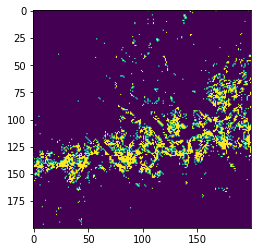

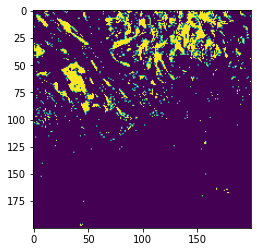

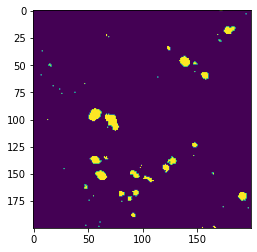

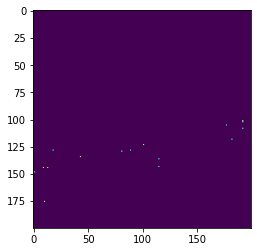

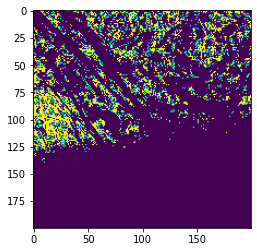

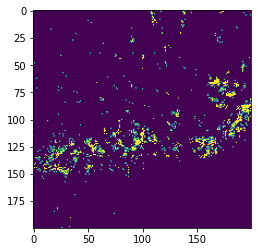

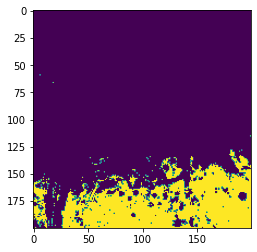

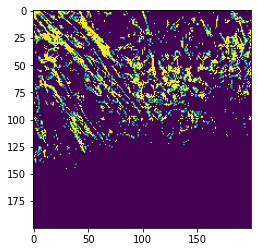

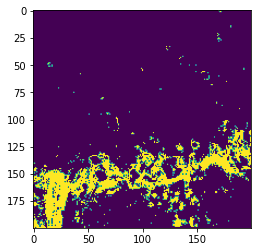

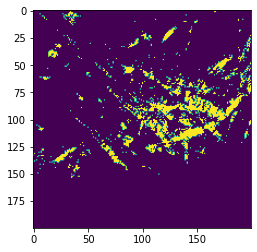

In [5]:
for i in range(15):
    plt.figure()
    plt.imshow(idx==i)